## 1. Imports et Configuration

In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import numpy as np
import time

# Configuration
plt.ion()
plt.style.use("default")

key = random.PRNGKey(42)
print("✅ Imports réalisés avec succès")

✅ Imports réalisés avec succès


## 2. Génération des Datasets 2D

Nous créons trois datasets de complexité croissante pour tester nos modèles :

In [2]:
def make_circles(n_samples: int = 1000, noise: float = 0.05, key: jax.random.PRNGKey = None):
    """Génère deux cercles concentriques"""
    if key is None:
        key = random.PRNGKey(0)

    key1, key2 = random.split(key, 2)
    labels = random.bernoulli(key1, 0.5, (n_samples,))
    angles = random.uniform(key2, (n_samples,), minval=0, maxval=2 * jnp.pi)
    radii = jnp.where(labels, 1.0, 0.3)

    x = radii * jnp.cos(angles)
    y = radii * jnp.sin(angles)

    noise_key1, noise_key2 = random.split(key, 2)
    x += random.normal(noise_key1, (n_samples,)) * noise
    y += random.normal(noise_key2, (n_samples,)) * noise

    return jnp.stack([x, y], axis=1)


def make_moons(n_samples: int = 1000, noise: float = 0.1, key: jax.random.PRNGKey = None):
    """Génère deux demi-lunes entrelacées"""
    if key is None:
        key = random.PRNGKey(0)

    key1, key2 = random.split(key, 2)

    n_outer = n_samples // 2
    n_inner = n_samples - n_outer

    # Lune extérieure
    outer_angles = random.uniform(key1, (n_outer,), minval=0, maxval=jnp.pi)
    outer_x = jnp.cos(outer_angles)
    outer_y = jnp.sin(outer_angles)

    # Lune intérieure
    inner_angles = random.uniform(key2, (n_inner,), minval=0, maxval=jnp.pi)
    inner_x = 1 - jnp.cos(inner_angles)
    inner_y = 1 - jnp.sin(inner_angles) - 0.5

    x = jnp.concatenate([outer_x, inner_x])
    y = jnp.concatenate([outer_y, inner_y])

    noise_key1, noise_key2 = random.split(key, 2)
    x += random.normal(noise_key1, (n_samples,)) * noise
    y += random.normal(noise_key2, (n_samples,)) * noise

    return jnp.stack([x, y], axis=1)


def make_gaussian_mixture(n_samples: int = 1000, key: jax.random.PRNGKey = None):
    """Génère un mélange de deux gaussiennes"""
    if key is None:
        key = random.PRNGKey(0)

    key1, key2 = random.split(key, 2)

    # Deux gaussiennes
    labels = random.bernoulli(key1, 0.5, (n_samples,))

    # Centre 1: (-1.5, -1.5), Centre 2: (1.5, 1.5)
    centers = jnp.array([[-1.5, -1.5], [1.5, 1.5]])

    samples = random.normal(key2, (n_samples, 2)) * 0.3
    samples = jnp.where(labels[:, None], samples + centers[1], samples + centers[0])

    return samples


print("✅ Fonctions de génération de datasets définies")

✅ Fonctions de génération de datasets définies


## 3. Visualisation des Datasets

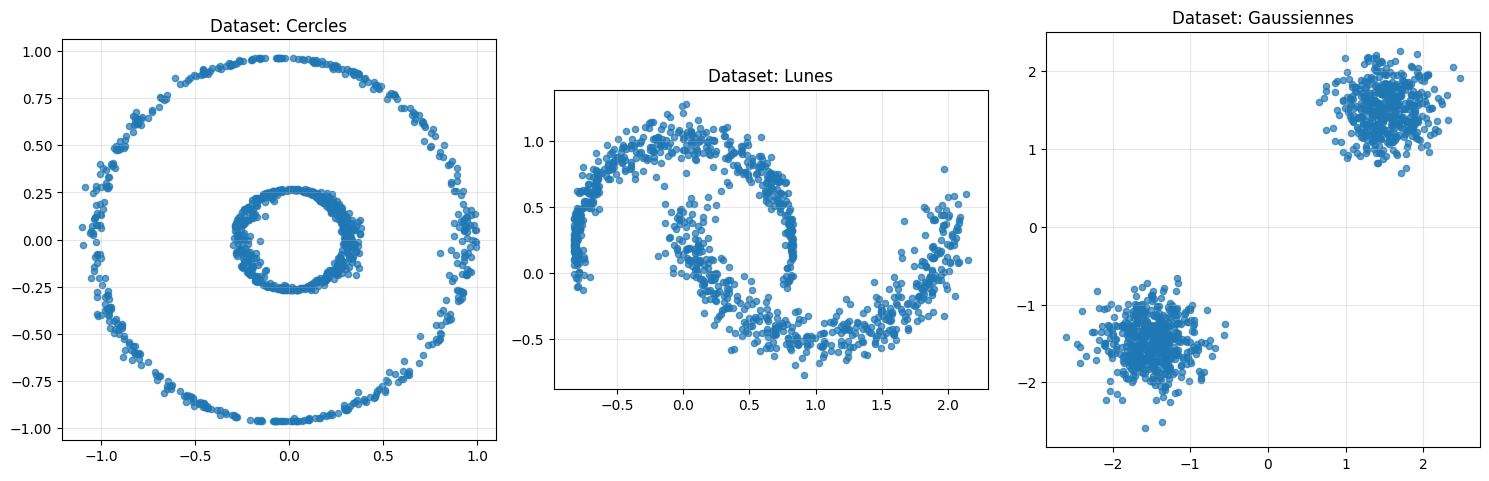

📊 Datasets générés et visualisés


In [3]:
# Créons et visualisons nos trois datasets
key1, key2, key3 = random.split(key, 3)

datasets = {
    "Cercles": make_circles(1000, 0.05, key1),
    "Lunes": make_moons(1000, 0.1, key2),
    "Gaussiennes": make_gaussian_mixture(1000, key3),
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (name, data) in enumerate(datasets.items()):
    axes[i].scatter(data[:, 0], data[:, 1], alpha=0.7, s=20)
    axes[i].set_title(f"Dataset: {name}")
    axes[i].set_aspect('equal')
    axes[i].grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()
print("📊 Datasets générés et visualisés")

## 4. Architecture des Réseaux de Neurones

Implémentation du MLP avec choix d'activation (tanh ou ELU) :

In [4]:
class MLP(eqx.Module):
    """Perceptron Multi-Couches avec choix d'activation"""
    layers: list
    use_elu: bool

    def __init__(self, in_size, hidden_sizes, out_size, key, activation="tanh"):
        keys = random.split(key, len(hidden_sizes) + 1)
        sizes = [in_size] + hidden_sizes + [out_size]

        # Stocker un booléen simple
        self.use_elu = (activation == "elu")

        self.layers = []
        for i in range(len(sizes) - 1):
            self.layers.append(eqx.nn.Linear(sizes[i], sizes[i + 1], key=keys[i]))

    def __call__(self, x):
        for layer in self.layers[:-1]:
            if self.use_elu:
                x = jax.nn.elu(layer(x))
            else:
                x = jax.nn.tanh(layer(x))
        return self.layers[-1](x)


print("✅ Classe MLP définie avec support tanh/ELU")

✅ Classe MLP définie avec support tanh/ELU


## 5. Implémentation des Flots Normalisants (RealNVP)

Architecture spécialisée pour la dimension 2 avec couches alternées :

In [14]:
# TODO: Implémentez la classe RealNVPLayer
"""
EXERCICE 1: Implémentation de RealNVPLayer

Principe mathématique :
- Transformation bijective : z = f(x) où x peut être récupéré exactement
- Masquage : Une partie des dimensions reste inchangée, l'autre est transformée
- Pour dim=2 : x[0] reste fixe, x[1] est transformé selon x[0]

Architecture :
- 2 réseaux MLP : net_s (échelle) et net_t (translation)
- Transformation : z1 = x1 * exp(s(x0)) + t(x0)
- Jacobien diagonal : determinant = s pour efficacité

Méthodes à implémenter :
1. __init__(hidden_sizes, key) : Créer les 2 MLPs avec activation tanh
2. forward(x) : Transformation x → z + calcul du log-déterminant
3. inverse(z) : Transformation inverse z → x

Astuce : Utilisez jnp.clip(s, -2, 2) pour la stabilité numérique
"""

# TODO: Implémentez la classe RealNVPLayerFlipped
"""
EXERCICE 2: Implémentation de RealNVPLayerFlipped

Principe :
- Même architecture que RealNVPLayer mais masquage inversé
- x[1] reste fixe, x[0] est transformé selon x[1]
- Permet d'alterner les transformations pour couvrir toutes les dimensions

"""

print("📝 TODO: Implémentez les classes selon les principes ci-dessus")

📝 TODO: Implémentez les classes selon les principes ci-dessus


In [6]:
class NormalizingFlow(eqx.Module):
    """Flot Normalisant complet avec couches RealNVP alternées"""
    layers: list

    def __init__(self, num_layers, hidden_sizes, key):
        keys = random.split(key, num_layers)
        self.layers = []

        for i, k in enumerate(keys):
            if i % 2 == 0:
                layer = RealNVPLayer(hidden_sizes, k)
            else:
                layer = RealNVPLayerFlipped(hidden_sizes, k)
            self.layers.append(layer)

    def forward(self, x):
        """Transformation directe : data -> latent"""
        log_det_total = 0.0
        for layer in self.layers:
            x, log_det = layer.forward(x)
            log_det_total += log_det
        return x, log_det_total

    def log_prob(self, x):
        """Calcul de la log-probabilité"""
        def single_log_prob(x_single):
            z, log_det = self.forward(x_single)
            log_prob_base = -0.5 * jnp.sum(z**2) - jnp.log(2 * jnp.pi)
            return log_prob_base + log_det

        if x.ndim == 2:
            return jax.vmap(single_log_prob)(x)
        else:
            return single_log_prob(x)

    def sample(self, num_samples, key):
        """Génération d'échantillons : latent -> data"""
        z = random.normal(key, (num_samples, 2))

        def single_sample(z_single):
            x = z_single
            for layer in reversed(self.layers):
                x, _ = layer.inverse(x)
            return x

        return jax.vmap(single_sample)(z)


print("✅ Classe NormalizingFlow complète définie")

✅ Classe NormalizingFlow complète définie


## 6. Implémentation du Flow Matching

Apprentissage de champs de vitesse pour la génération continue :

In [ ]:
# TODO: Implémentez la classe FlowMatching
"""
EXERCICE 3: Implémentation de FlowMatching

Principe mathématique :
- Apprentissage d'un champ de vitesse v(x,t) pour transformer du bruit vers les données
- Équation différentielle : dx/dt = v(x,t)
- Chemin simple : interpolation linéaire entre source x0 et cible x1

Architecture :
- Un seul réseau MLP : velocity_net prenant (x, t) en entrée
- Entrée de dimension (dim + 1) pour concaténer position et temps
- Activation ELU recommandée pour les gradients

Méthodes à implémenter :
1. __init__(dim, hidden_sizes, key) : Créer le MLP velocity_net
2. velocity_field(x, t) : Calcul du champ de vitesse en (x,t)

Principe d'entraînement :
- Échantillonner x0 ~ N(0,I), x1 ~ données, t ~ Uniform[0,1]
- Calculer x_t = (1-t)*x0 + t*x1 (interpolation linéaire)
- Vitesse vraie : v_true = x1 - x0
- Minimiser ||v(x_t, t) - v_true||²
"""

# TODO: Implémentez la fonction sample_flow_matching
"""
EXERCICE 4: Génération par Flow Matching

Principe :
- Partir du bruit gaussien x ~ N(0,I)
- Intégrer l'équation dx/dt = v(x,t) de t=0 à t=1
- Méthode d'Euler : x_{t+dt} = x_t + v(x_t, t) * dt

Paramètres :
- model : modèle FlowMatching entraîné
- num_samples : nombre d'échantillons à générer
- steps : nombre de pas d'intégration (plus élevé = plus précis)
"""

print("📝 TODO: Implémentez FlowMatching et sample_flow_matching selon les principes ci-dessus")

✅ Classe FlowMatching et fonction de sampling définies


## 7. Fonctions d'Entraînement

Implémentation des boucles d'optimisation pour les deux approches :

In [8]:
def train_normalizing_flow(model, data, epochs=800, lr=2e-3, batch_size=64):
    """Entraînement par maximisation de la vraisemblance"""
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(model)

    def loss_fn(model, batch):
        log_probs = model.log_prob(batch)
        return -jnp.mean(log_probs)  # Maximisation de la vraisemblance

    @eqx.filter_jit
    def step(model, opt_state, batch):
        loss, grads = eqx.filter_value_and_grad(loss_fn)(model, batch)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss

    losses = []
    n_samples = data.shape[0]

    for epoch in range(epochs):
        key, subkey = random.split(random.PRNGKey(epoch))
        idx = random.randint(subkey, (batch_size,), 0, n_samples)
        batch = data[idx]

        model, opt_state, loss = step(model, opt_state, batch)
        losses.append(loss)

        if epoch % 200 == 0:
            print(f"Époque {epoch}, Perte NF: {loss:.4f}")

    return model, losses


def train_flow_matching(model, data, epochs=1000, lr=1e-2, batch_size=256):
    """Entraînement par minimisation de l'erreur sur le champ de vitesse"""
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(model)

    key = random.PRNGKey(123)  # Clé locale pour l'entraînement

    def loss_fn(model, x1_batch, key):
        batch_size = x1_batch.shape[0]
        dim = x1_batch.shape[1]

        # Échantillonner source et temps
        x0_batch = random.normal(key, (batch_size, dim))
        key, subkey = random.split(key)
        t_batch = random.uniform(subkey, (batch_size,))

        def single_loss(x0, x1, t):
            # Chemin linéaire simple
            x_t = (1 - t) * x0 + t * x1
            v_true = x1 - x0  # Vitesse vraie pour le chemin linéaire
            v_pred = model.velocity_field(x_t, t)
            return jnp.sum((v_pred - v_true) ** 2)

        losses = jax.vmap(single_loss)(x0_batch, x1_batch, t_batch)
        return jnp.mean(losses)

    @eqx.filter_jit
    def step(model, opt_state, batch, key):
        loss, grads = eqx.filter_value_and_grad(loss_fn)(model, batch, key)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss

    losses = []
    n_samples = data.shape[0]

    for epoch in range(epochs):
        key, subkey = random.split(key)
        idx = random.randint(subkey, (batch_size,), 0, n_samples)
        batch = data[idx]

        key, subkey = random.split(key)
        model, opt_state, loss = step(model, opt_state, batch, subkey)
        losses.append(loss)

        if epoch % 250 == 0:
            print(f"  Époque {epoch}, Perte FM: {loss:.4f}")

    return model, losses


print("✅ Fonctions d'entraînement définies")

✅ Fonctions d'entraînement définies


## 8. Fonction de Visualisation Avancée

In [9]:
def plot_results(results):
    """Affiche tous les résultats avec des graphiques avancés"""
    for (
        dataset_name,
        data,
        nf_model,
        nf_losses,
        nf_samples,
        fm_model,
        fm_losses,
        fm_samples,
    ) in results:
        # Visualisation améliorée - 2x3 grille
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle(
            f"Comparaison Flots Normalisants vs Flow Matching - {dataset_name}",
            fontsize=18,
            fontweight="bold",
        )

        # Ligne 1: Données et échantillons
        # Données originales
        axes[0, 0].scatter(
            data[:, 0],
            data[:, 1],
            alpha=0.7,
            s=30,
            c="blue",
            edgecolors="navy",
            linewidth=0.5,
        )
        axes[0, 0].set_title(
            f"Données Originales\n{dataset_name}", fontsize=14, fontweight="bold"
        )
        axes[0, 0].set_aspect("equal")
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_xlabel("X", fontsize=12)
        axes[0, 0].set_ylabel("Y", fontsize=12)

        # Échantillons Flots Normalisants
        axes[0, 1].scatter(
            nf_samples[:, 0],
            nf_samples[:, 1],
            alpha=0.7,
            s=30,
            c="red",
            edgecolors="darkred",
            linewidth=0.5,
        )
        axes[0, 1].set_title(
            f"Flots Normalisants\nPerte finale: {nf_losses[-1]:.3f}",
            fontsize=14,
            fontweight="bold",
        )
        axes[0, 1].set_aspect("equal")
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_xlabel("X", fontsize=12)
        axes[0, 1].set_ylabel("Y", fontsize=12)

        # Échantillons Flow Matching
        axes[0, 2].scatter(
            fm_samples[:, 0],
            fm_samples[:, 1],
            alpha=0.7,
            s=30,
            c="green",
            edgecolors="darkgreen",
            linewidth=0.5,
        )
        axes[0, 2].set_title(
            f"Flow Matching\nPerte finale: {fm_losses[-1]:.3f}",
            fontsize=14,
            fontweight="bold",
        )
        axes[0, 2].set_aspect("equal")
        axes[0, 2].grid(True, alpha=0.3)
        axes[0, 2].set_xlabel("X", fontsize=12)
        axes[0, 2].set_ylabel("Y", fontsize=12)

        # Ligne 2: Courbes de perte et comparaison
        # Courbe de perte Flots Normalisants
        axes[1, 0].plot(
            nf_losses, "r-", linewidth=3, alpha=0.8, label="Flots Normalisants"
        )
        axes[1, 0].set_title(
            "Évolution Perte - Flots Normalisants", fontsize=14, fontweight="bold"
        )
        axes[1, 0].set_xlabel("Époque", fontsize=12)
        axes[1, 0].set_ylabel("Perte", fontsize=12)
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_facecolor("#fdf2f2")

        # Courbe de perte Flow Matching
        axes[1, 1].plot(fm_losses, "g-", linewidth=3, alpha=0.8, label="Flow Matching")
        axes[1, 1].set_title(
            "Évolution Perte - Flow Matching", fontsize=14, fontweight="bold"
        )
        axes[1, 1].set_xlabel("Époque", fontsize=12)
        axes[1, 1].set_ylabel("Perte", fontsize=12)
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].set_facecolor("#f2fdf2")

        # Comparaison superposée
        axes[1, 2].scatter(
            data[:, 0],
            data[:, 1],
            alpha=0.4,
            s=15,
            c="blue",
            label="Original",
            edgecolors="navy",
            linewidth=0.3,
        )
        axes[1, 2].scatter(
            nf_samples[:, 0],
            nf_samples[:, 1],
            alpha=0.6,
            s=15,
            c="red",
            label="Flots Norm.",
            edgecolors="darkred",
            linewidth=0.3,
        )
        axes[1, 2].scatter(
            fm_samples[:, 0],
            fm_samples[:, 1],
            alpha=0.6,
            s=15,
            c="green",
            label="Flow Match.",
            edgecolors="darkgreen",
            linewidth=0.3,
        )
        axes[1, 2].legend(fontsize=10)
        axes[1, 2].set_title("Comparaison Superposée", fontsize=14, fontweight="bold")
        axes[1, 2].set_aspect("equal")
        axes[1, 2].grid(True, alpha=0.3)
        axes[1, 2].set_xlabel("X", fontsize=12)
        axes[1, 2].set_ylabel("Y", fontsize=12)

        plt.tight_layout()

        # Sauvegarde et affichage
        filename = (
            f"/Users/franck/Desktop/TP/comparison_complete_{dataset_name.lower()}.png"
        )
        plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")
        plt.show()
        plt.pause(5)  # Pause plus longue pour admirer !

        print(f"Graphique complet sauvé: {filename}")
        print(f"Résumé {dataset_name}: NF={nf_losses[-1]:.3f}, FM={fm_losses[-1]:.3f}")
        print("-" * 80)


print("✅ Fonction de visualisation définie")

✅ Fonction de visualisation définie


## 9. Expérimentation Complète

Entraînement et comparaison des deux méthodes sur tous les datasets :

In [10]:
def run_experiments():
    """Lance les expérimentations complètes"""
    print("=== Test Flots et Flow Matching avec Visualisations Améliorées ===")

    key = random.PRNGKey(42)
    key1, key2, key3 = random.split(key, 3)

    datasets = {
        "Cercles": make_circles(1000, 0.05, key1),
        "Lunes": make_moons(1000, 0.1, key2),
        "Gaussiennes": make_gaussian_mixture(1000, key3),
    }

    # Stocker tous les résultats
    results = []

    for dataset_name, data in datasets.items():
        print(f"\n=== Dataset: {dataset_name} ===")

        print("\n--- Flot Normalisant ---")
        key, subkey = random.split(key)
        nf_model = NormalizingFlow(8, [32, 32], subkey)

        nf_model, nf_losses = train_normalizing_flow(nf_model, data, epochs=4000)

        key, subkey = random.split(key)
        nf_samples = nf_model.sample(1000, subkey)

        print(f"Perte finale NF: {nf_losses[-1]:.4f}")

        print("\n--- Flow Matching ---")
        key, subkey = random.split(key)
        fm_model = FlowMatching(2, [40] * 4, subkey)

        fm_model, fm_losses = train_flow_matching(fm_model, data, epochs=10000)

        key, subkey = random.split(key)
        fm_samples = sample_flow_matching(fm_model, 1000, 100, subkey)

        print(f"Perte finale FM: {fm_losses[-1]:.4f}")

        # Stocker les résultats au lieu d'afficher immédiatement
        results.append(
            (
                dataset_name,
                data,
                nf_model,
                nf_losses,
                nf_samples,
                fm_model,
                fm_losses,
                fm_samples,
            )
        )

    return results


print("✅ Fonction d'expérimentation définie")

✅ Fonction d'expérimentation définie


## 10. Exécution des Expérimentations

⚠️ **Attention** : Cette cellule peut prendre plusieurs minutes à s'exécuter (entraînement de 6 modèles)

In [11]:
# Lancer les expérimentations
print("🚀 Début des expérimentations...")
start_time = time.time()

results = run_experiments()

end_time = time.time()
print(f"⏱️ Expérimentations terminées en {end_time - start_time:.1f} secondes")

🚀 Début des expérimentations...
=== Test Flots et Flow Matching avec Visualisations Améliorées ===

=== Dataset: Cercles ===

--- Flot Normalisant ---
Époque 0, Perte NF: 2.5320
Époque 0, Perte NF: 2.5320
Époque 200, Perte NF: 1.4127
Époque 200, Perte NF: 1.4127
Époque 400, Perte NF: 0.7068
Époque 400, Perte NF: 0.7068
Époque 600, Perte NF: 0.6097
Époque 600, Perte NF: 0.6097
Époque 800, Perte NF: 0.5540
Époque 800, Perte NF: 0.5540
Époque 1000, Perte NF: 0.1635
Époque 1000, Perte NF: 0.1635
Époque 1200, Perte NF: 0.3370
Époque 1200, Perte NF: 0.3370
Époque 1400, Perte NF: 0.2891
Époque 1400, Perte NF: 0.2891
Époque 1600, Perte NF: 0.3686
Époque 1600, Perte NF: 0.3686
Époque 1800, Perte NF: 0.1447
Époque 1800, Perte NF: 0.1447
Époque 2000, Perte NF: -0.0231
Époque 2000, Perte NF: -0.0231
Époque 2200, Perte NF: -0.1685
Époque 2200, Perte NF: -0.1685
Époque 2400, Perte NF: 0.5016
Époque 2400, Perte NF: 0.5016
Époque 2600, Perte NF: -0.3776
Époque 2600, Perte NF: -0.3776
Époque 2800, Pert

## 11. Affichage des Résultats Visuels


=== Affichage de tous les graphiques ===


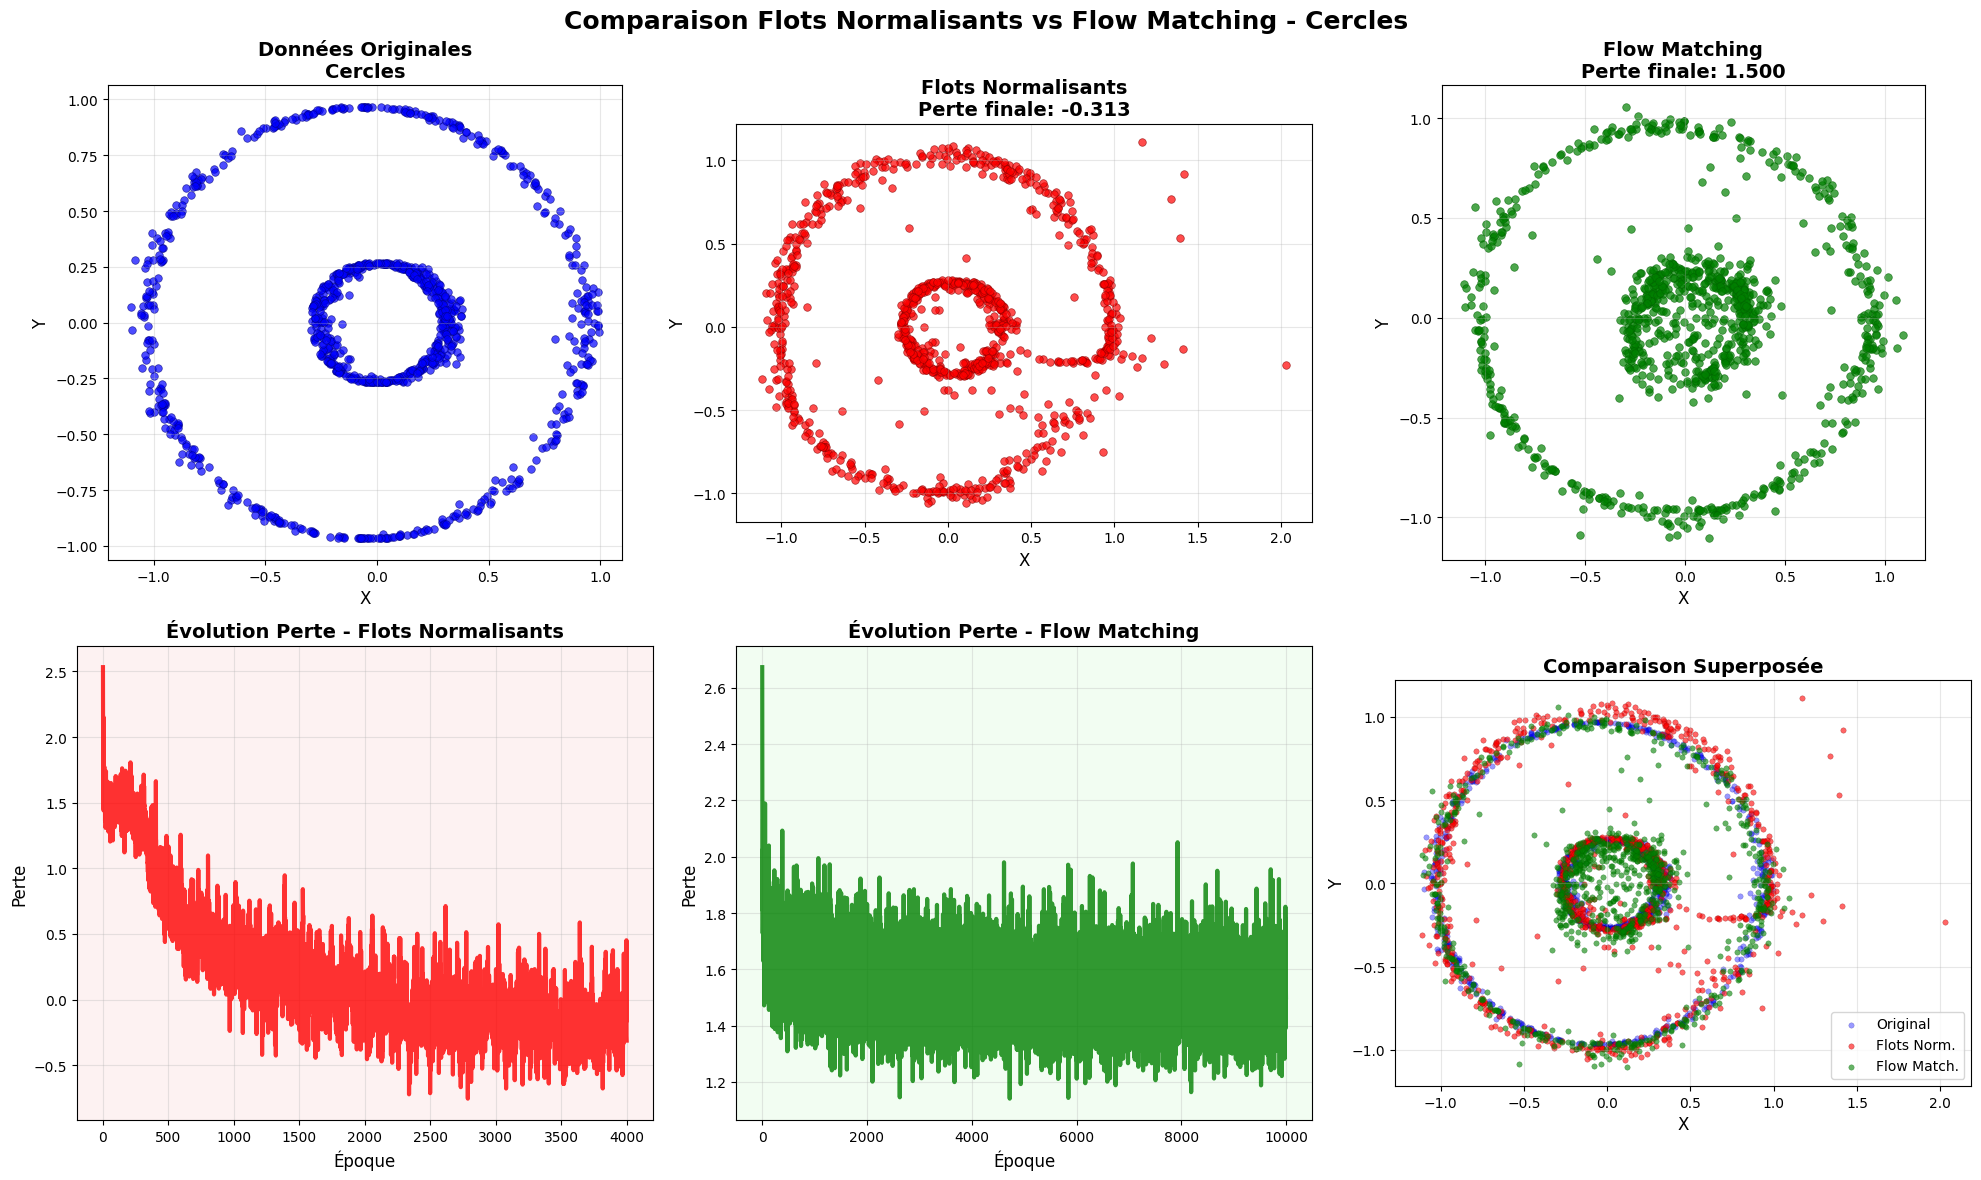

Graphique complet sauvé: /Users/franck/Desktop/TP/comparison_complete_cercles.png
Résumé Cercles: NF=-0.313, FM=1.500
--------------------------------------------------------------------------------


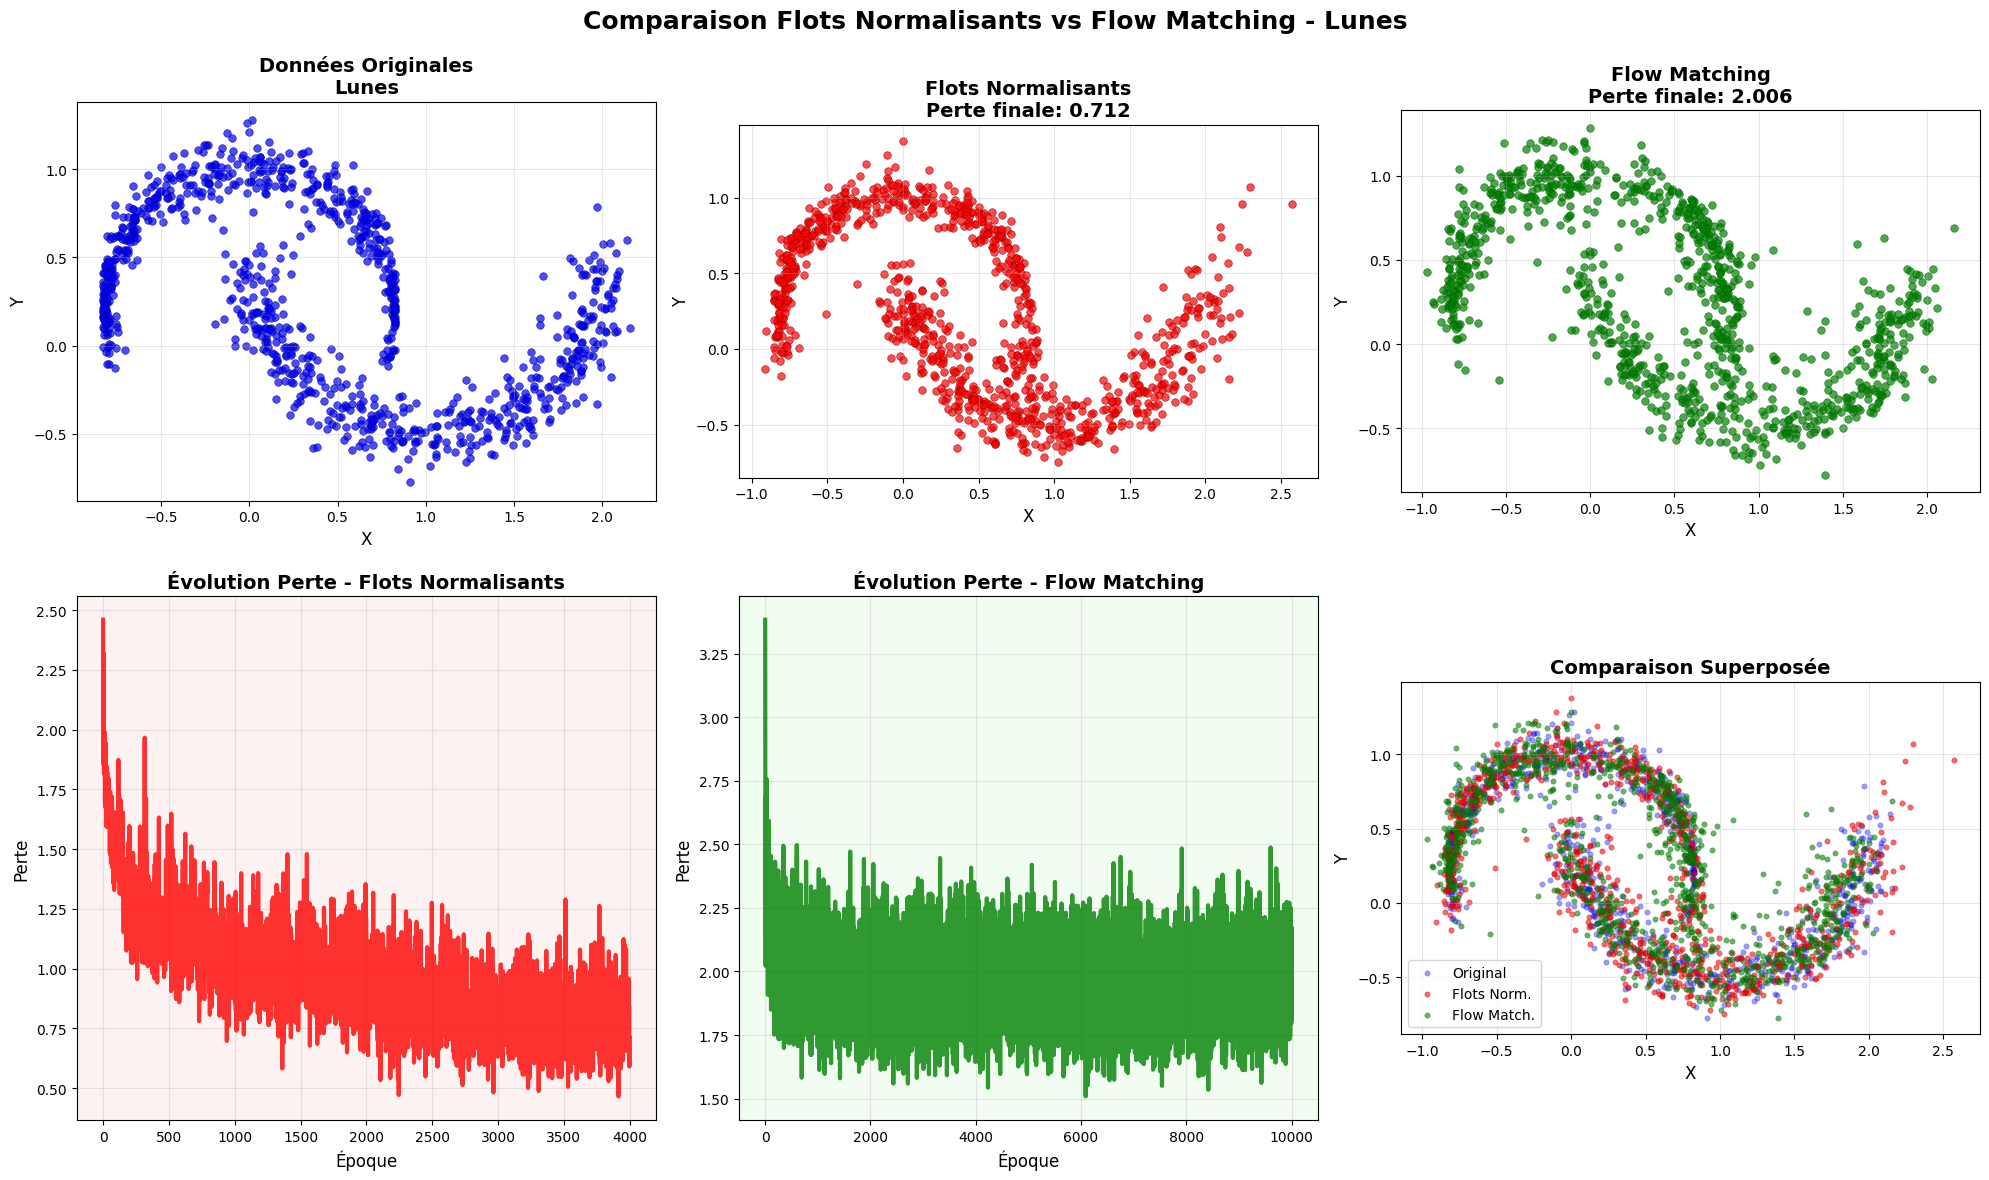

Graphique complet sauvé: /Users/franck/Desktop/TP/comparison_complete_lunes.png
Résumé Lunes: NF=0.712, FM=2.006
--------------------------------------------------------------------------------


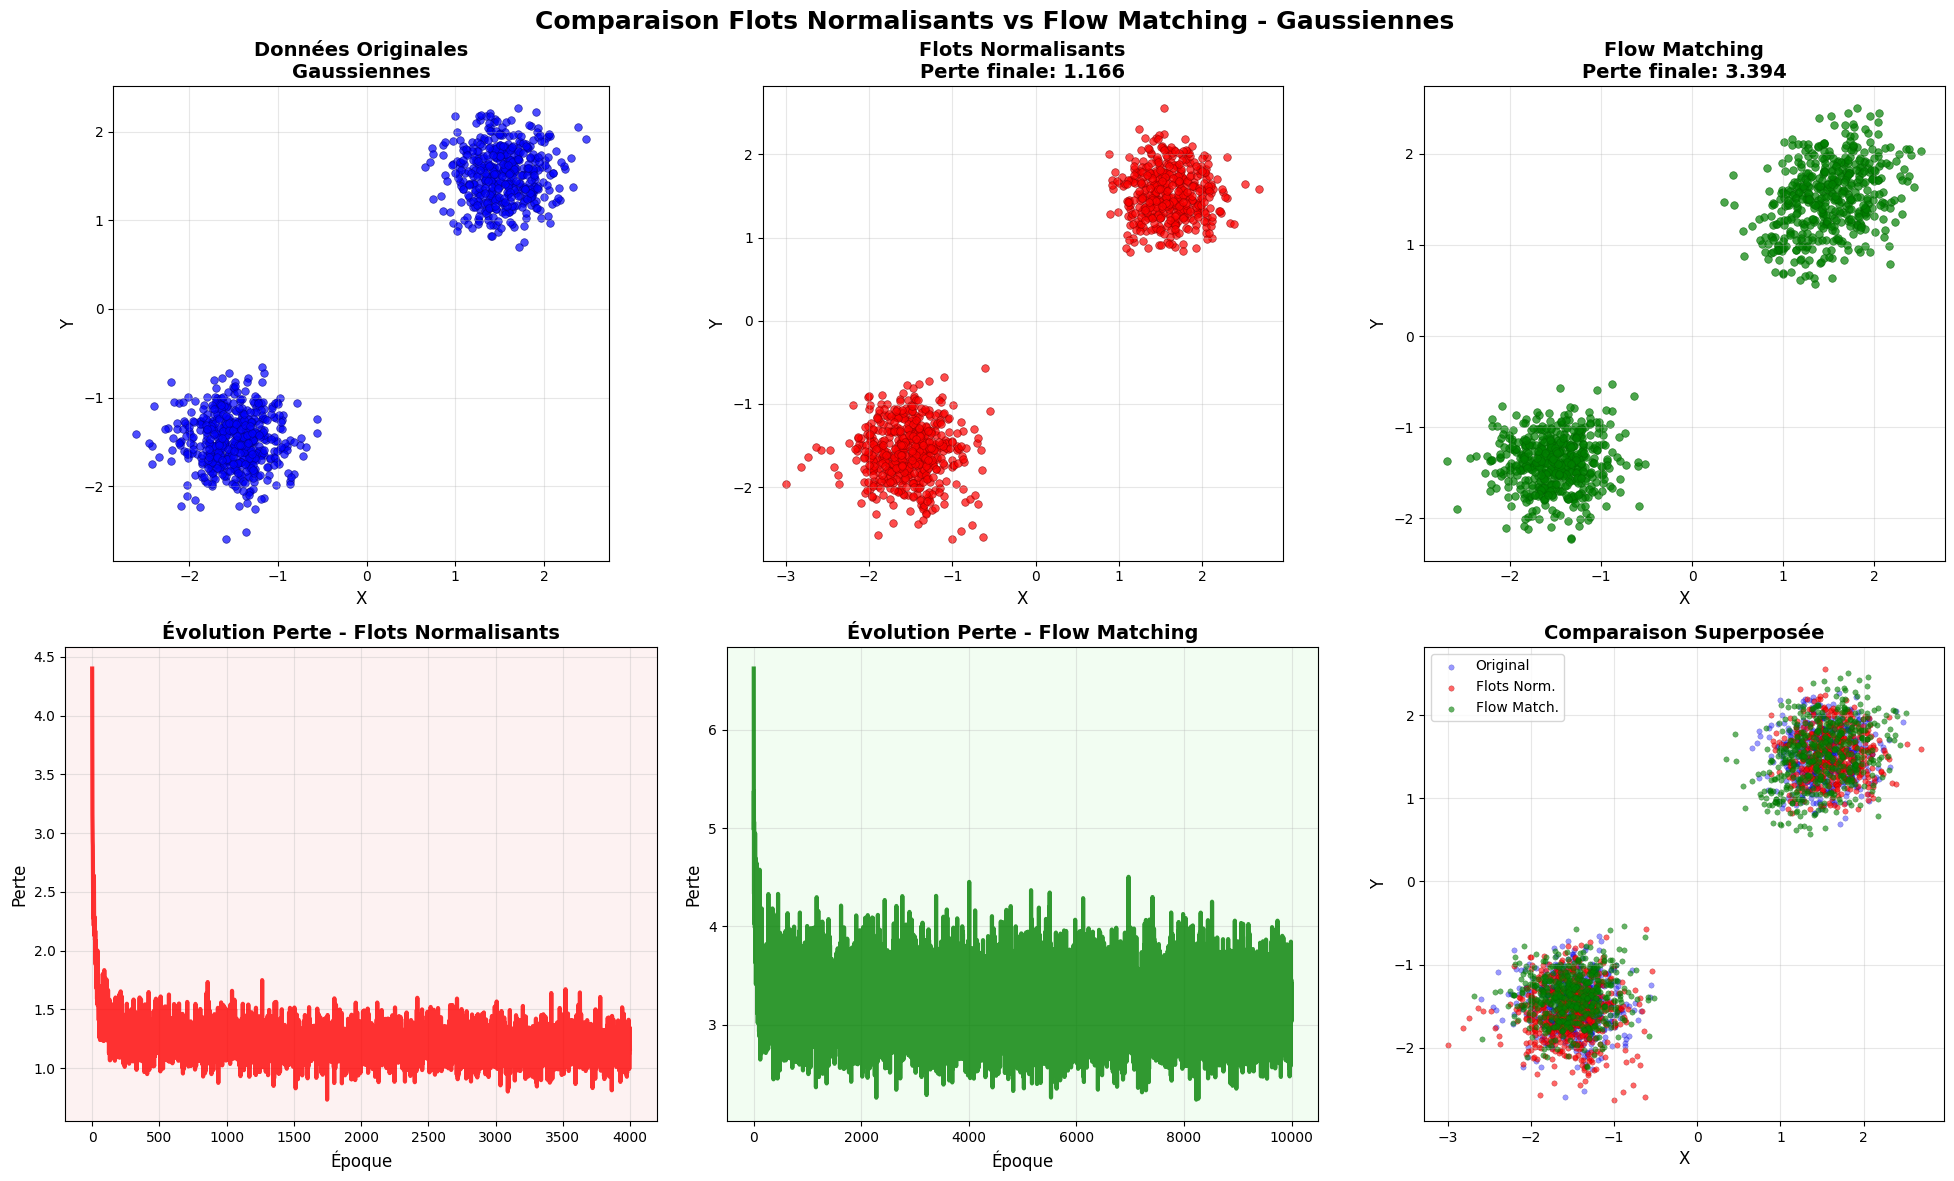

Graphique complet sauvé: /Users/franck/Desktop/TP/comparison_complete_gaussiennes.png
Résumé Gaussiennes: NF=1.166, FM=3.394
--------------------------------------------------------------------------------


In [12]:
# Afficher tous les plots
print("\n=== Affichage de tous les graphiques ===")
plot_results(results)

In [ ]:
# Test rapide sur un dataset
def quick_test(dataset_name="Cercles", epochs_nf=1000, epochs_fm=2000):
    """Test rapide avec moins d'époques pour validation"""
    print(f"🚀 Test rapide sur {dataset_name}")
    
    key = random.PRNGKey(123)
    
    # Génération du dataset
    if dataset_name == "Cercles":
        data = make_circles(500, 0.05, key)
    elif dataset_name == "Lunes":
        data = make_moons(500, 0.1, key)
    else:
        data = make_gaussian_mixture(500, key)
    
    # Entraînement rapide
    key, k1, k2 = random.split(key, 3)
    
    # Flot Normalisant
    nf_model = NormalizingFlow(4, [32], k1)
    nf_model, nf_losses = train_normalizing_flow(nf_model, data, epochs=epochs_nf)
    nf_samples = nf_model.sample(500, k1)
    
    # Flow Matching
    fm_model = FlowMatching(2, [32, 32], k2)
    fm_model, fm_losses = train_flow_matching(fm_model, data, epochs=epochs_fm)
    fm_samples = sample_flow_matching(fm_model, 500, 50, k2)
    
    # Visualisation
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].scatter(data[:, 0], data[:, 1], alpha=0.7, s=20, c='blue')
    axes[0].set_title(f"Données Originales\n{dataset_name}")
    axes[0].set_aspect('equal')
    
    axes[1].scatter(nf_samples[:, 0], nf_samples[:, 1], alpha=0.7, s=20, c='red')
    axes[1].set_title(f"Flots Normalisants\nPerte: {nf_losses[-1]:.3f}")
    axes[1].set_aspect('equal')
    
    axes[2].scatter(fm_samples[:, 0], fm_samples[:, 1], alpha=0.7, s=20, c='green')
    axes[2].set_title(f"Flow Matching\nPerte: {fm_losses[-1]:.3f}")
    axes[2].set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Résultats: NF={nf_losses[-1]:.3f}, FM={fm_losses[-1]:.3f}")


# Décommenter la ligne suivante pour faire un test rapide :
# quick_test("Cercles", 500, 1000)

print("✅ Fonction de test rapide définie")